# <span style="color: crimson">Прогнозирование заказов такси</span>
---
**<span style="color: crimson">Заказчик</span>**: компания «Чётенькое такси».     
**<span style="color: crimson">Цель анализа</span>**: построить модель для предсказания количество заказов такси на следующий час.  
**<span style="color: crimson">Датаст</span>**: исторические данные о заказах такси в аэропортах.

---

## Импорт библиотек:

In [1]:
!pip3 install pmdarima
!pip3 install optuna
!pip3 install lightgbm

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from pylab import rcParams
import optuna

import warnings

warnings.filterwarnings("ignore")

In [3]:
def rmse(test, predictions):
    return np.sqrt(mean_squared_error(test, predictions))

## <span style="color: crimson">Этап 1</span> Изучение и подготовка данных

In [4]:
df = pd.read_csv('./taxi.csv', parse_dates=[0], index_col=[0])

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Взглянем на диапазон:**

In [12]:
str(df['num_orders'].index.date.min()) + ' to ' +str(df['num_orders'].index.date.max())

'2018-03-01 to 2018-08-31'

1. Со столь узким диапазоном значений нет смысла использовать int64
2. У нас данные за 6 месяцев 2018 с 3 по 8.

**Изменим тип данных у колонки num_orders:**

In [13]:
df['num_orders'] = df['num_orders'].astype('uint8')

**Проверим, в хронологическом ли порядке расположены даты и время:**

In [14]:
df.index.is_monotonic

True

### <center><span style="color: crimson"><b>Вывод</b></span></center>  
В данных отсутствуют аномалии.

## <span style="color: crimson">Этап 2</span> Анализ данных

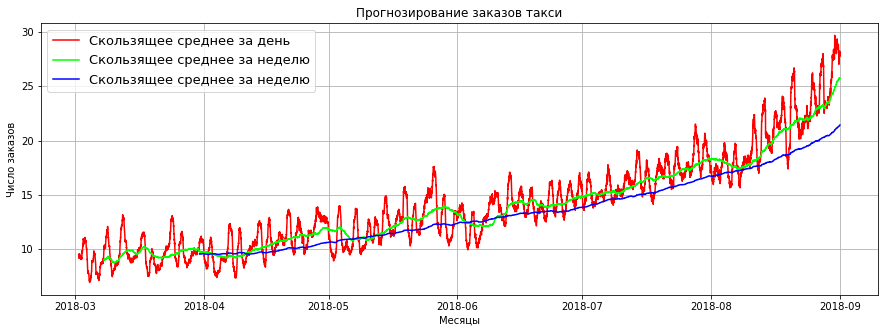

In [10]:
plt.figure(figsize=(15,5))

plt.plot(df['num_orders'].rolling(window = 6*24).mean(), "r", label = 'Скользящее среднее за день')
plt.plot(df['num_orders'].rolling(window = 6*24*7).mean(), "lime", label = 'Скользящее среднее за неделю')
plt.plot(df['num_orders'].rolling(window = 6*24*30).mean(), "b", label = 'Скользящее среднее за неделю')

plt.title('Прогнозирование заказов такси')
plt.xlabel('Месяцы')
plt.ylabel('Число заказов')
plt.legend(loc = 'upper left', fontsize = 13)
plt.grid(True)

Как видно временной ряд нестационарен.

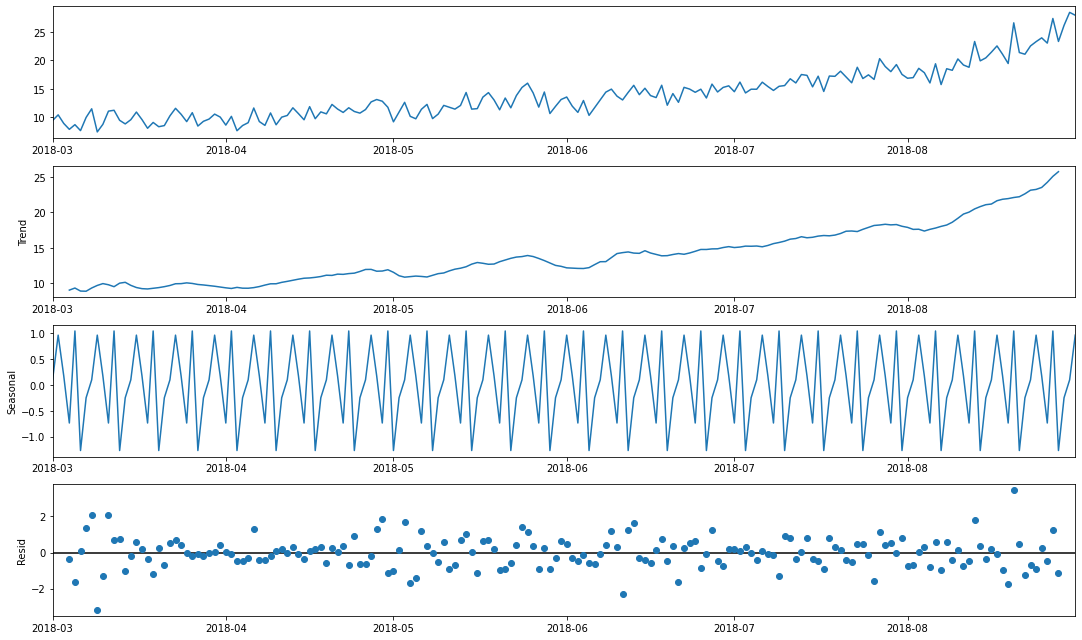

In [11]:
# задаем размер графика
rcParams['figure.figsize'] = 15, 9

# применяем функцию к данным о перевозках
decompose = seasonal_decompose(df.resample('D').mean())
decompose.plot()
 
plt.show()

Сезонность: недельная.

**Воспользуемся автокорреляцией, чтобы найти необходимое кол-во отстающих признаков**

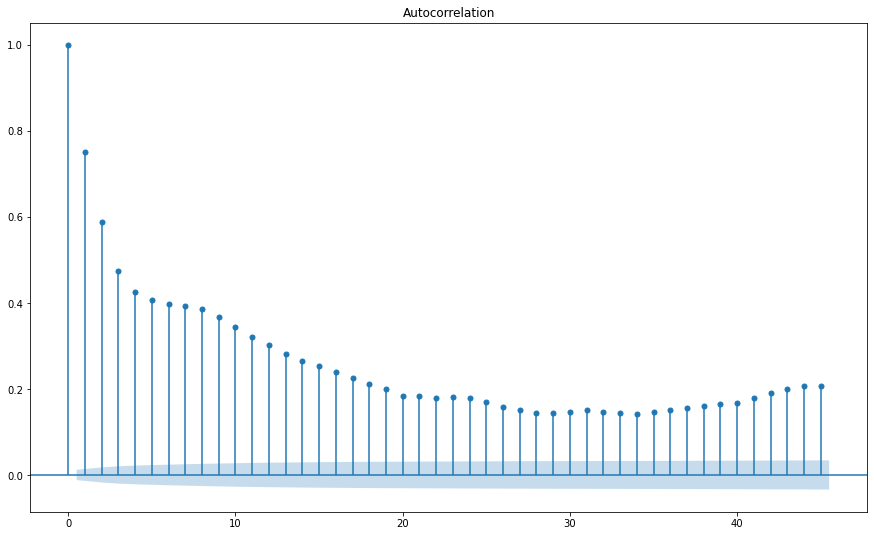

In [12]:
plot_acf(df);

Как видно наша автокорреляция выходит за пределы стат. значимости, а это значит что она достаточно сильна и ее можно использовать при построении модели

### <center><span style="color: crimson"><b>Вывод</b></span></center>  
* Временной ряд нестационарен.
* Сезонность: недельная.
*  Автокорреляция выходит за пределы стат. значимости, а это значит что она достаточно сильна и ее можно использовать при построении модели.

## <span style="color: crimson">Этап 3</span>  Создание и тестирование моделей 

In [13]:
# выполним ресемплирование по одному часу
df = df.resample('1H').sum()

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

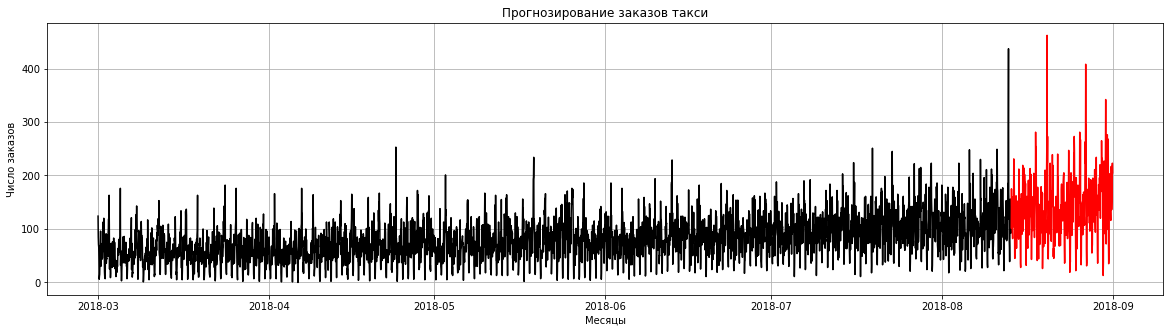

In [14]:
plt.figure(figsize=(20, 5))

plt.plot(train, color="black")
plt.plot(test, color="red")

# заголовок и подписи к осям
plt.title("Прогнозирование заказов такси")
plt.xlabel("Месяцы")
plt.ylabel("Число заказов")

# добавим сетку
plt.grid()

plt.show()

**Модели:**
1. SARIMAX
2. LightGBMRegressor (Градиентный бустин)
3. LinearRegression

### SARIMAX

In [15]:
# # обучение модели (крашнет ваш комп)
# parameter_search = auto_arima(
#     train,
#     start_p=1,
#     start_q=1,
#     max_p=3,
#     max_q=3,
#     m=24,
#     start_P=0,
#     seasonal=True,
#     d=None,
#     D=1,
#     trace=True,
#     error_action="ignore",
#     suppress_warnings=True,
#     stepwise=True,
# )  
  
# # выведем результат
# print(parameter_search.summary())

In [16]:
SARIMAX = SARIMAX(train, 
                order = (3, 0, 0), 
                seasonal_order = (0, 1, 0, 24)).fit()

In [17]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
 
# и закончится в конце тестового
end = len(train) + len(test) - 1
  
# применим метод predict
predictions_SARIMAX = SARIMAX.predict(start, end)
SARIMAX_RMSE = rmse(test, predictions_SARIMAX)
print('RMSE:', SARIMAX_RMSE)

#### Изменим данные для работы с регрессионными моделями

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data["dayofweek"] = data.index.dayofweek
    data["hours"] = data.index.hour

    for lag in range(1, max_lag + 1):
        data["lag_{}".format(lag)] = data["num_orders"].shift(lag)
    data["rolling_mean"] = data["num_orders"].shift().rolling(rolling_mean_size).mean()



make_features(df, 2, 24)

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(["num_orders"], axis=1)
target_train = train["num_orders"]
features_test = test.drop(["num_orders"], axis=1)
target_test = test["num_orders"]

### LightGBMRegressor

Настраиваем библиотеку optuna для поиска гиперпараметров

In [20]:
# RANDOM_SEED = 666


# def tune(objective):
#     study = optuna.create_study(direction="maximize")
#     study.optimize(objective, n_trials=100)

#     params = study.best_params
#     best_score = study.best_value
#     print(f"Best score: {best_score}\n")
#     print(f"Optimized parameters: {params}\n")
#     return params

In [21]:
# def LGBM_objective(trial):
#     param_grid = {
#         "num_leaves": trial.suggest_int("num_leaves", 1, 100),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, step=0.01),
#         "max_depth": trial.suggest_int("max_depth", 1, 10),
#         "n_estimators": trial.suggest_int("n_estimators", 10, 500),
#     }
    
#     tss = TimeSeriesSplit(n_splits=8).split(train)
#     LGBM = LGBMRegressor(**param_grid, random_state=RANDOM_SEED)
#     scores = cross_val_score(
#         LGBM,
#         features_train,
#         target_train,
#         cv=tss,
#         scoring="neg_root_mean_squared_error",
#     )
#     return scores.mean()


# LGBM_params = tune(LGBM_objective)
# LGBM = LGBMRegressor(**LGBM_params, random_state=RANDOM_SEED)

In [22]:
LGBM = LGBMRegressor(num_leaves=47, learning_rate=0.07, max_depth=7, n_estimators=499, random_state=666)
LGBM.fit(features_train, target_train)
predictions_LGBM = LGBM.predict(features_test)
LGBMR_RMSE = rmse(predictions_LGBM, target_test)
print("RMSE:", LGBMR_RMSE)

---

### LinearRegression

In [23]:
LR = LinearRegression()
LR.fit(features_train, target_train)
predictions_LR = LR.predict(features_test)
Linear_RMSE = rmse(predictions_LR,target_test)
print('RMSE:', Linear_RMSE)

---

## <span style="color: crimson">Этап 4</span>  Общий вывод

In [24]:
pd.DataFrame(
    [
        [
            "SARIMAX",
            SARIMAX_RMSE,
            "10 s",
            "> 4h",
        ],
        ["Линейная регрессия", Linear_RMSE, "249 ms", "0"],
        [
            "Градиентный бустинг (LGBM)",
            LGBMR_RMSE,
            "3.17 s",
            "4 min 9s",
        ],
    ],
    columns=("Модель", " RMSE", "Время предсказание", "Время поиска гиперпараметров"),
)

Взглянем на предсказание на графике

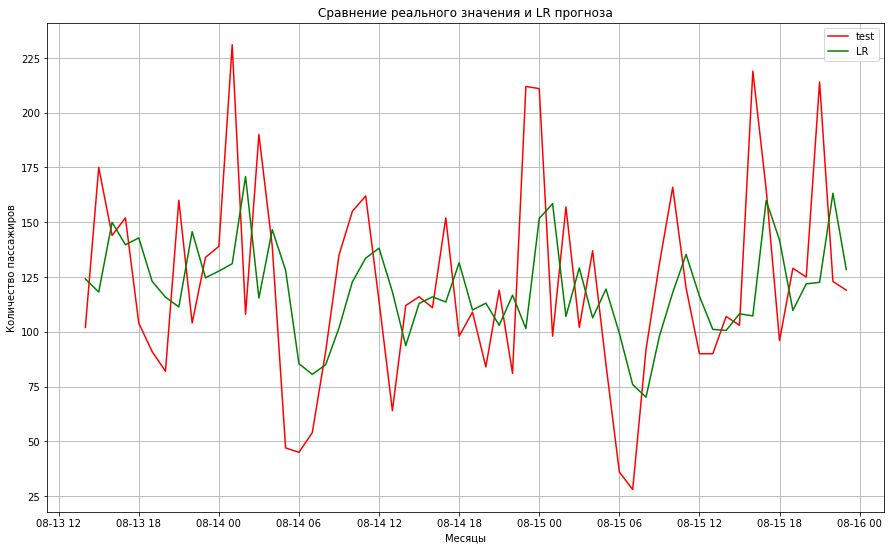

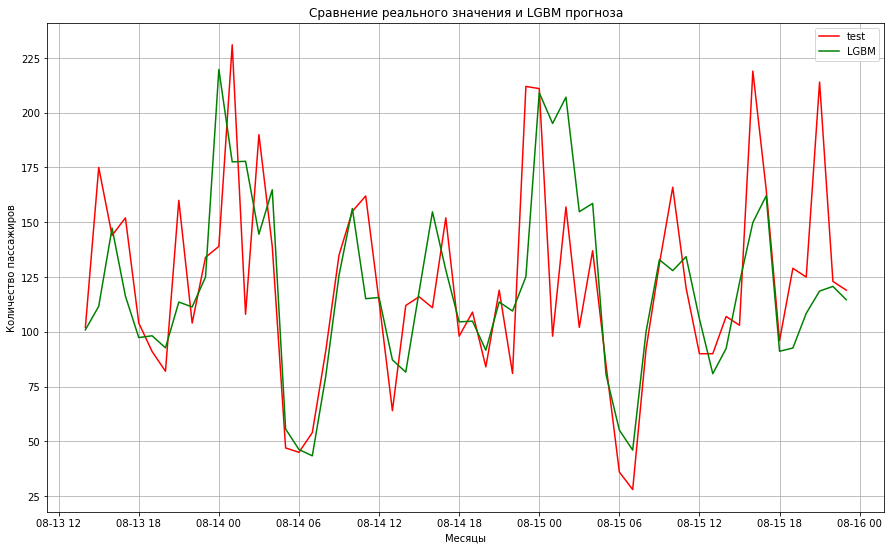

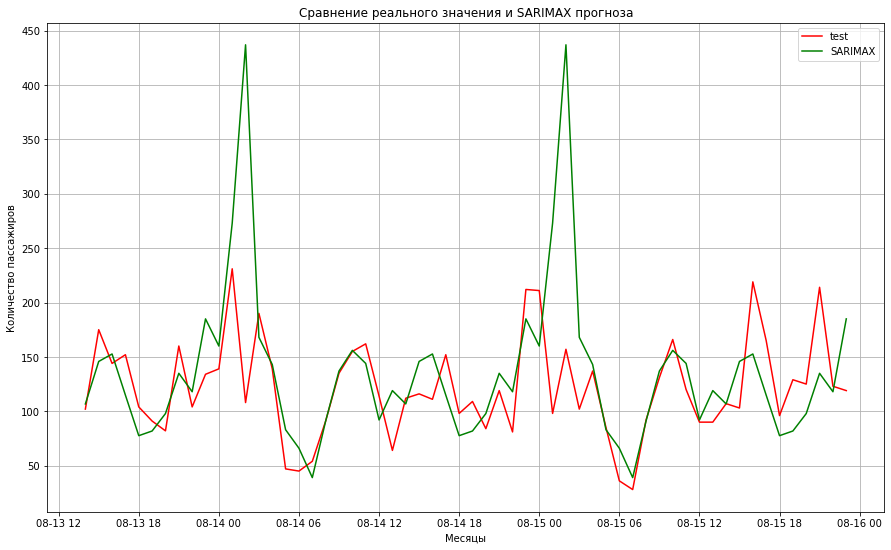

In [25]:
def grafic(model_1, label): 
    s_interval = "2018-08-13"
    e_interval = "2018-08-15"
    

    plt.plot(test["num_orders"][s_interval:e_interval], color="r", label="test")
    plt.plot(model_1[s_interval:e_interval], color="g", label=label)

    # заголовок и подписи к осям
    plt.title("Сравнение реального значения и " + label + " прогноза")
    plt.ylabel("Количество пассажиров")
    plt.xlabel("Месяцы")

    # добавим сетку
    plt.grid()
    plt.legend()
    plt.show()


predictions_LR = pd.DataFrame(predictions_LR, index=test.index)
predictions_LGBM = (
    pd.DataFrame(predictions_LGBM, index=test.index)
)

grafic(predictions_LR, "LR")
grafic(predictions_LGBM, "LGBM")
grafic(predictions_SARIMAX, "SARIMAX")

**Вывод:** 
Наиболее оптимальная модель это LGBMRegressor с гиперпараметры  num_leaves=47, learning_rate=0.07, max_depth=7, n_estimators=499, random_state=666.